In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('laptopData_PROCESSED.csv')

# Separate features and target
X = data.drop('Price', axis=1)
y = data['Price']

# Identify numerical columns that need scaling
numerical_features = ['Ram', 'Weight', 'PPI', 'Total_Memory_GB']


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Scaling only numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = numeric_transformer.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = numeric_transformer.transform(X_test[numerical_features])

In [14]:
# Helper Functions

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation (5-fold)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -np.mean(cv_scores)
    
    print(f"--- {name} ---")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test R²: {r2:.4f}")
    print(f"5-Fold CV RMSE: {cv_rmse:.2f}\n")
    
    return {"Model": name, "Test_RMSE": rmse, "Test_MAE": mae, "Test_R2": r2, "CV_RMSE": cv_rmse}

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Predicted vs Actual Prices - {model_name}')
    plt.show()

In [15]:
# Model Training and Evaluation

results = []

--- Linear Regression ---
Test RMSE: 15286.71
Test MAE: 11592.08
Test R²: 0.7044
5-Fold CV RMSE: 14562.41



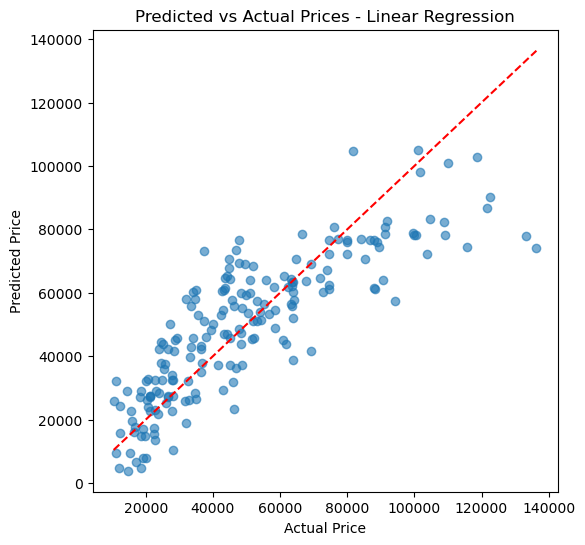

In [16]:
# Linear Regression

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
results.append(evaluate_model("Linear Regression", linear_model, X_train_scaled, y_train, X_test_scaled, y_test))
plot_predictions(y_test, linear_model.predict(X_test_scaled), "Linear Regression")

--- Random Forest (Tuned) ---
Test RMSE: 12602.14
Test MAE: 9020.27
Test R²: 0.7991
5-Fold CV RMSE: 12697.77



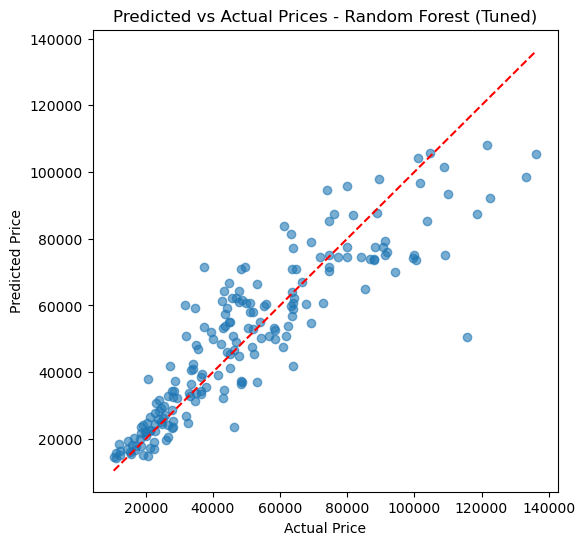

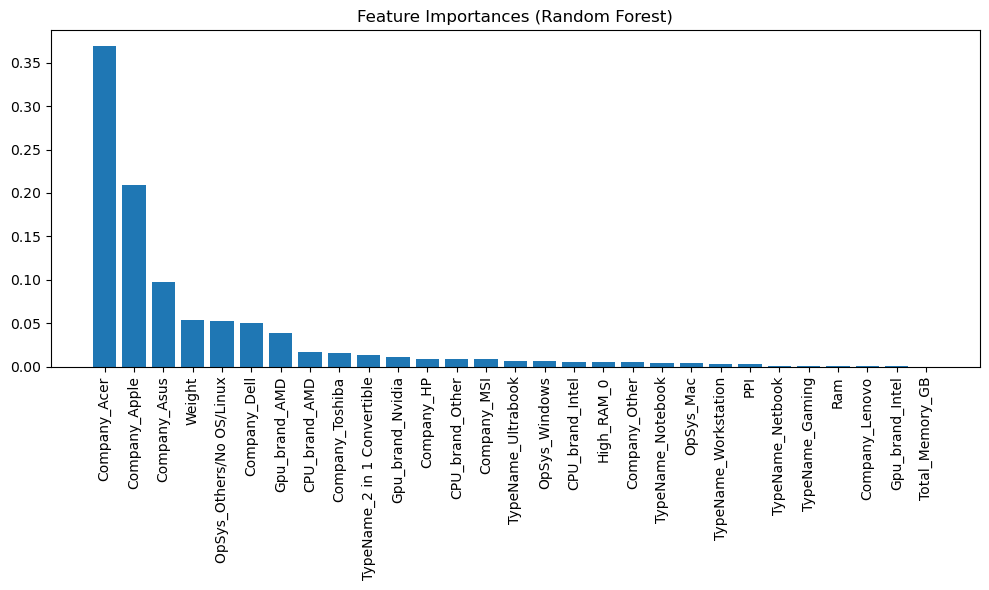

In [20]:
# Random Forest (with tuning)

rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train_scaled, y_train)
results.append(evaluate_model("Random Forest (Tuned)", rf_model, X_train_scaled, y_train, X_test_scaled, y_test))
plot_predictions(y_test, rf_model.predict(X_test_scaled), "Random Forest (Tuned)")

# Feature Importance Plot for Random Forest
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_scaled.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train_scaled.shape[1]), importances[indices])
plt.xticks(range(X_train_scaled.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


--- Gradient Boosting (Tuned) ---
Test RMSE: 12554.52
Test MAE: 9200.40
Test R²: 0.8006
5-Fold CV RMSE: 12518.33



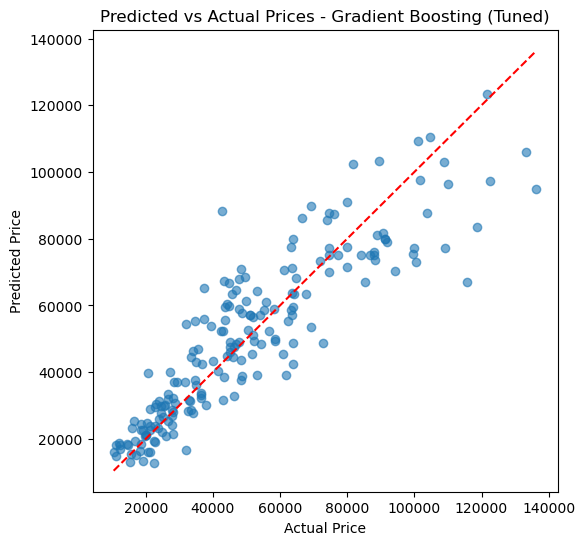

In [18]:
# Gradient Boosting (with tuning)

gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)
results.append(evaluate_model("Gradient Boosting (Tuned)", gb_model, X_train_scaled, y_train, X_test_scaled, y_test))
plot_predictions(y_test, gb_model.predict(X_test_scaled), "Gradient Boosting (Tuned)")

In [19]:
# Final Model Comparison

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
display(results_df.sort_values(by="Test_RMSE"))


Model Comparison:


,Model,Test_RMSE,Test_MAE,Test_R2,CV_RMSE
2,Gradient Boosting (Tuned),12554.524349,9200.401538,0.800590,12518.327565
1,Random Forest (Tuned),12602.142694,9020.269882,0.799074,12697.774175
0,Linear Regression,15286.710489,11592.083177,0.704352,14562.413272
